In [1]:
import sys
sys.path.append("..")

from src.preprocess import load_data, clean_data
from src.features import create_features

In [2]:
import yfinance as yf

# Download AAPL historical data
df = yf.download("AAPL", start="2018-01-01", end="2024-01-01")

[*********************100%***********************]  1 of 1 completed


In [3]:
# 2. Load data
df = load_data("AAPL", "2018-01-01", "2024-01-01")

# 3. Clean data
df = clean_data(df)

# 4. Save raw CSV
df.to_csv("data/raw/aapl.csv", index=False)

# 5. Quick check
df.head()


[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
0,2018-01-02,40.341892,40.351262,39.639317,39.850091,102223600
1,2018-01-03,40.334869,40.878196,40.271640,40.405128,118071600
2,2018-01-04,40.522213,40.625258,40.299731,40.407458,89738400
3,2018-01-05,40.983574,41.070224,40.526901,40.618235,94640000
4,2018-01-08,40.831348,41.126429,40.732985,40.831348,82271200


In [4]:
df.describe()


Price,Date,Close,High,Low,Open,Volume
count,1509,1509.000000,1509.000000,1509.000000,1509.000000,1.509000e+03
mean,2020-12-30 14:13:07.276342016,107.824407,108.952048,106.584251,107.724452,1.073284e+08
min,2018-01-02 00:00:00,33.799671,34.638779,33.754506,34.225167,2.404830e+07
25%,2019-07-03 00:00:00,51.237423,52.040457,50.858421,51.374818,7.078370e+07
50%,2020-12-30 00:00:00,120.464729,121.718822,118.965600,120.605518,9.296430e+07
75%,2022-06-30 00:00:00,150.220779,151.972500,148.223238,150.046364,1.280440e+08
max,2023-12-29 00:00:00,196.256577,197.752444,195.156959,196.167422,4.265100e+08
std,NaN,50.934094,51.407897,50.406557,50.893120,5.513287e+07


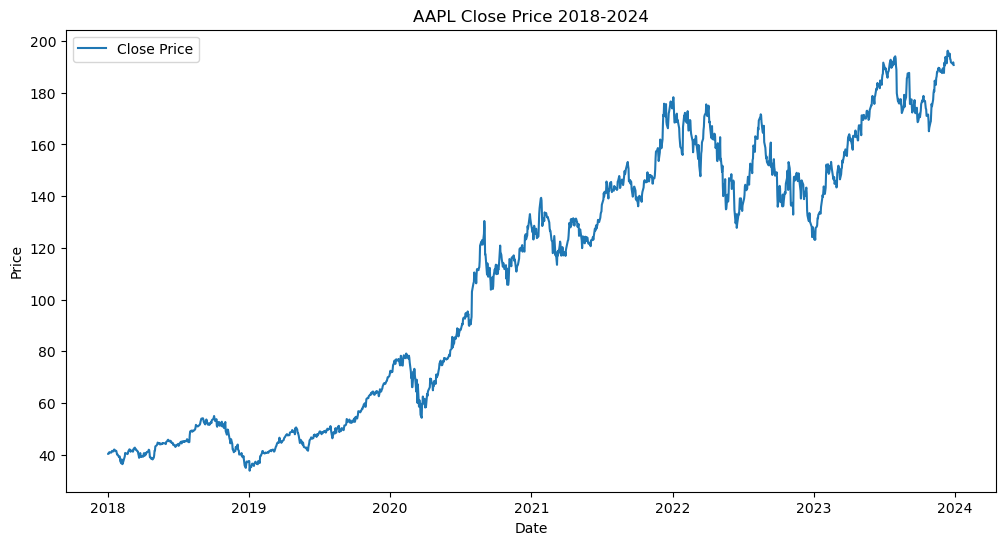

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.title('AAPL Close Price 2018-2024')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


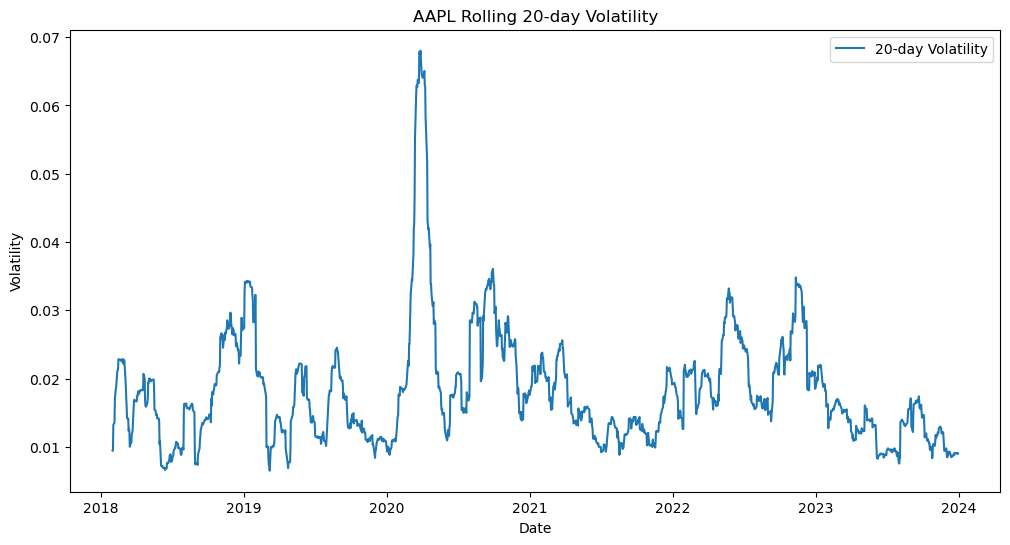

In [6]:
# Compute returns
df['Return'] = df['Close'].pct_change()

# 20-day rolling volatility
df['Volatility_20'] = df['Return'].rolling(window=20).std()

# Plot
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Volatility_20'], label='20-day Volatility')
plt.title('AAPL Rolling 20-day Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


In [7]:
df_features = create_features(df)
df_features.head()

Price,Date,Close,High,Low,Open,Volume,Return,Volatility_20,RollingMean_5,RollingMean_20
20,2018-01-31,39.210735,39.447271,38.992939,39.079588,129915600,0.002755,0.009462,39.577489,40.771045
21,2018-02-01,39.292709,39.489430,39.053833,39.149852,188923200,0.002091,0.009490,39.421517,40.718937
22,2018-02-02,37.587795,39.063205,37.494120,38.875851,346375200,-0.043390,0.013250,38.905828,40.572216
23,2018-02-05,36.648674,38.379351,36.533919,37.259915,290954000,-0.024985,0.013567,38.368587,40.355471
24,2018-02-06,38.180294,38.341887,36.065542,36.259922,272975200,0.041792,0.017207,38.184042,40.222919


In [8]:
from src.models import train_models
from src.evaluation import evaluate, max_drawdown

lr, rf, X_test, y_test = train_models(df_features)

lr_pred = lr.predict(X_test)
rf_pred = rf.predict(X_test)

rmse_lr, mae_lr = evaluate(y_test, lr_pred)
rmse_rf, mae_rf = evaluate(y_test, rf_pred)

rmse_lr, rmse_rf 


(np.float64(0.015828131909040942), np.float64(0.018038290073982992))

In [9]:
drawdown = max_drawdown(y_test)
drawdown

-0.19592024892822302

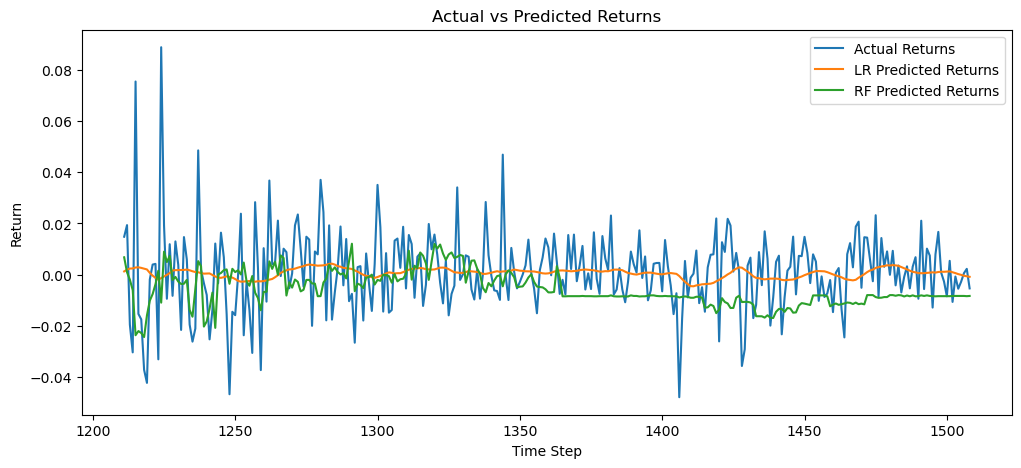

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label='Actual Returns')
plt.plot(y_test.index, lr_pred, label='LR Predicted Returns')
plt.plot(y_test.index, rf_pred, label='RF Predicted Returns')
plt.title('Actual vs Predicted Returns')
plt.xlabel('Time Step')
plt.ylabel('Return')
plt.legend()
plt.show()


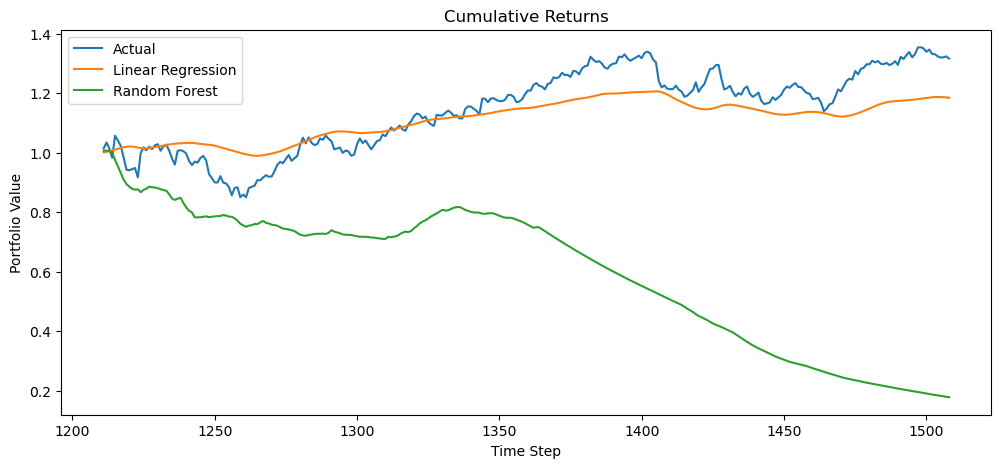

In [11]:
import numpy as np
import pandas as pd

# Cumulative returns
cumulative_actual = (1 + y_test).cumprod()
cumulative_lr = (1 + pd.Series(lr_pred, index=y_test.index)).cumprod()
cumulative_rf = (1 + pd.Series(rf_pred, index=y_test.index)).cumprod()

plt.figure(figsize=(12,5))
plt.plot(cumulative_actual, label='Actual')
plt.plot(cumulative_lr, label='Linear Regression')
plt.plot(cumulative_rf, label='Random Forest')
plt.title('Cumulative Returns')
plt.xlabel('Time Step')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()


In [12]:
print(f"Linear Regression RMSE: {rmse_lr:.6f}, MAE: {mae_lr:.6f}")
print(f"Random Forest RMSE: {rmse_rf:.6f}, MAE: {mae_rf:.6f}")
print(f"Maximum Drawdown: {drawdown:.6f}")


Linear Regression RMSE: 0.015828, MAE: 0.011473
Random Forest RMSE: 0.018038, MAE: 0.013571
Maximum Drawdown: -0.195920


In [13]:
from src.evaluation import directional_accuracy

da_lr = directional_accuracy(y_test, lr_pred)
da_rf = directional_accuracy(y_test, rf_pred)

print(f"LR Directional Accuracy: {da_lr:.2%}")
print(f"RF Directional Accuracy: {da_rf:.2%}")


LR Directional Accuracy: 50.67%
RF Directional Accuracy: 46.64%


In [14]:
from src.optimized_models import (
    split_data,
    train_linear_regression,
    train_random_forest,
    train_gradient_boosting
)

# Split data
X_train, X_test, y_train, y_test = split_data(df_features)

# Train models
lr = train_linear_regression(X_train, y_train)
rf = train_random_forest(X_train, y_train)
gbr = train_gradient_boosting(X_train, y_train)

# Predictions
lr_pred = lr.predict(X_test)
rf_pred = rf.predict(X_test)
gbr_pred = gbr.predict(X_test)



In [15]:
rmse_gbr, mae_gbr = evaluate(y_test, gbr_pred)
da_gbr = directional_accuracy(y_test, gbr_pred)

print(f"GBR RMSE: {rmse_gbr:.6f}")
print(f"GBR MAE: {mae_gbr:.6f}")
print(f"GBR Directional Accuracy: {da_gbr:.2%}")

GBR RMSE: 0.020499
GBR MAE: 0.016378
GBR Directional Accuracy: 52.35%


In [16]:
def sharpe_ratio(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    return excess_returns.mean() / excess_returns.std()


strategy_returns = y_test * np.sign(gbr_pred)
print("Sharpe Ratio:", sharpe_ratio(strategy_returns))


Sharpe Ratio: 0.03931456591409273


In [17]:
from src.backtest import walk_forward_validation
from src.optimized_models import train_gradient_boosting

features = [
    "RollingMean_5",
    "RollingMean_20",
    "Volatility_20"
]

preds, actuals = walk_forward_validation(
    df_features,
    train_gradient_boosting,
    features,
    "Return"
)


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.backtest import walk_forward_validation
from src.optimized_models import train_gradient_boosting
from src.evaluation import evaluate, directional_accuracy, max_drawdown


In [19]:
FEATURES = [
    "RollingMean_5",
    "RollingMean_20",
    "Volatility_20"
]

TARGET = "Return"


In [20]:
preds, actuals = walk_forward_validation(
    df_features,
    train_gradient_boosting,
    FEATURES,
    TARGET,
    window=252
)

len(preds), len(actuals)


(1237, 1237)

In [21]:
actuals = pd.Series(actuals)
rmse_wf, mae_wf = evaluate(actuals, preds)
da_wf = directional_accuracy(actuals, preds)
dd_wf = max_drawdown(actuals)

print(f"Walk-Forward RMSE: {rmse_wf:.6f}")
print(f"Walk-Forward MAE: {mae_wf:.6f}")
print(f"Walk-Forward Directional Accuracy: {da_wf:.2%}")
print(f"Maximum Drawdown: {dd_wf:.2%}")


Walk-Forward RMSE: 0.027379
Walk-Forward MAE: 0.018305
Walk-Forward Directional Accuracy: 48.91%
Maximum Drawdown: -31.43%


In [22]:
signals = np.sign(preds)
strategy_returns = signals * actuals


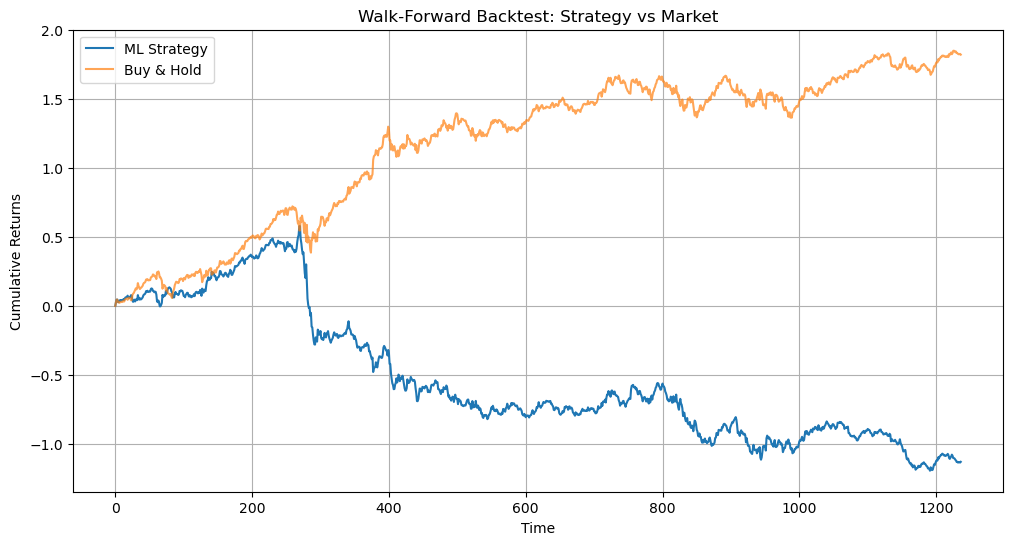

In [23]:
cum_strategy = np.cumsum(strategy_returns)
cum_market = np.cumsum(actuals)

plt.figure(figsize=(12,6))
plt.plot(cum_strategy, label="ML Strategy")
plt.plot(cum_market, label="Buy & Hold", alpha=0.7)
plt.title("Walk-Forward Backtest: Strategy vs Market")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()


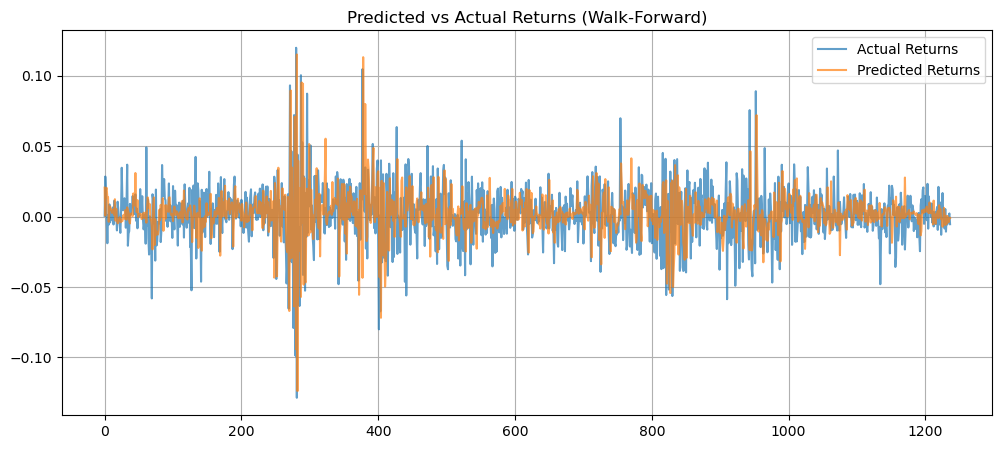

In [24]:
plt.figure(figsize=(12,5))
plt.plot(actuals, label="Actual Returns", alpha=0.7)
plt.plot(preds, label="Predicted Returns", alpha=0.7)
plt.title("Predicted vs Actual Returns (Walk-Forward)")
plt.legend()
plt.grid(True)
plt.show()


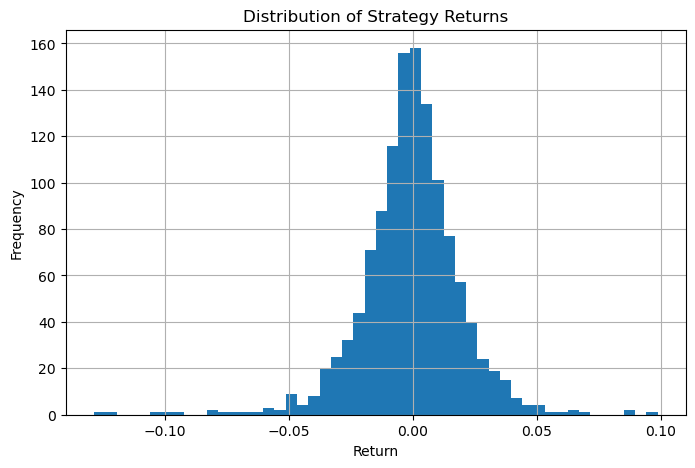

In [25]:
plt.figure(figsize=(8,5))
plt.hist(strategy_returns, bins=50)
plt.title("Distribution of Strategy Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [26]:
# Make a copy to avoid modifying original
df_enhanced = df_features.copy()

# Lagged returns (1–5 days)
for lag in range(1, 6):
    df_enhanced[f'Return_Lag_{lag}'] = df_enhanced['Return'].shift(lag)

# Momentum features (sum of past returns)
df_enhanced['Momentum_5'] = df_enhanced['Return'].rolling(5).sum()
df_enhanced['Momentum_10'] = df_enhanced['Return'].rolling(10).sum()

# Drop initial rows with NaNs from lag/rolling
df_enhanced = df_enhanced.dropna()

df_enhanced.head()
    

Price,Date,Close,High,Low,Open,Volume,Return,Volatility_20,RollingMean_5,RollingMean_20,Return_Lag_1,Return_Lag_2,Return_Lag_3,Return_Lag_4,Return_Lag_5,Momentum_5,Momentum_10
29,2018-02-13,38.644005,38.740416,38.011460,38.082004,130196800,0.010018,0.021235,37.476372,39.320592,0.040279,0.012231,-0.027517,-0.021407,0.041792,0.013604,-0.008133
30,2018-02-14,39.356503,39.396477,38.300696,38.338317,162579600,0.018437,0.021332,37.875078,39.191229,0.010018,0.040279,0.012231,-0.027517,-0.021407,0.053449,0.007550
31,2018-02-15,40.678017,40.701529,39.739780,39.925545,204588800,0.033578,0.022842,38.743708,39.126068,0.018437,0.010018,0.040279,0.012231,-0.027517,0.114543,0.039037
32,2018-02-16,40.546329,41.108333,40.391135,40.529871,160704400,-0.003237,0.022835,39.497115,39.063691,0.033578,0.018437,0.010018,0.040279,0.012231,0.099075,0.079190
33,2018-02-20,40.409962,40.976663,40.308847,40.456990,135722000,-0.003363,0.022783,39.926963,39.011591,-0.003237,0.033578,0.018437,0.010018,0.040279,0.055433,0.100811


In [27]:
FEATURES_ENHANCED = [
    "RollingMean_5",
    "RollingMean_20",
    "Volatility_20",
    "Momentum_5",
    "Momentum_10",
    "Return_Lag_1",
    "Return_Lag_2",
    "Return_Lag_3",
    "Return_Lag_4",
    "Return_Lag_5"
]

TARGET = "Return"


In [28]:
def walk_forward_threshold(df, model_fn, features, target, window=252, threshold=0.001):
    preds = []
    actuals = []
    signals = []

    for i in range(window, len(df)):
        train = df.iloc[i-window:i]
        test = df.iloc[i:i+1]

        X_train = train[features]
        y_train = train[target]
        X_test = test[features]

        model = model_fn(X_train, y_train)
        pred = model.predict(X_test)[0]

        # Thresholded signal
        signal = 0
        if pred > threshold:
            signal = 1
        elif pred < -threshold:
            signal = -1

        preds.append(pred)
        actuals.append(test[target].values[0])
        signals.append(signal)

    return np.array(preds), np.array(actuals), np.array(signals)


In [29]:
windows = [126, 252, 504]  # 0.5 year, 1 year, 2 years
threshold = 0.001  # adjust if needed

results = {}

for w in windows:
    preds_w, actuals_w, signals_w = walk_forward_threshold(
        df_enhanced, train_gradient_boosting, FEATURES_ENHANCED, TARGET, window=w, threshold=threshold
    )

    # Strategy returns
    strategy_returns = signals_w * actuals_w

    # Evaluate metrics
    rmse_wf, mae_wf = evaluate(actuals_w, preds_w)
    da_wf = directional_accuracy(actuals_w, preds_w)
    dd_wf = max_drawdown(strategy_returns)
    
    # Sharpe ratio
    sharpe = np.sqrt(252) * strategy_returns.mean() / strategy_returns.std()

    results[w] = {
        "RMSE": rmse_wf,
        "MAE": mae_wf,
        "Directional Accuracy": da_wf,
        "Max Drawdown": dd_wf,
        "Sharpe": sharpe
    }

# Display results
for w, metrics in results.items():
    print(f"Window {w}:")
    print(f"  RMSE: {metrics['RMSE']:.6f}")
    print(f"  MAE: {metrics['MAE']:.6f}")
    print(f"  Directional Accuracy: {metrics['Directional Accuracy']:.2%}")
    print(f"  Max Drawdown: {metrics['Max Drawdown']:.2%}")
    print(f"  Sharpe Ratio: {metrics['Sharpe']:.2f}\n")


Window 126:
  RMSE: 0.018095
  MAE: 0.012704
  Directional Accuracy: 67.87%
  Max Drawdown: -21.81%
  Sharpe Ratio: 6.72

Window 252:
  RMSE: 0.015442
  MAE: 0.010662
  Directional Accuracy: 73.78%
  Max Drawdown: -16.70%
  Sharpe Ratio: 9.27

Window 504:
  RMSE: 0.014593
  MAE: 0.010022
  Directional Accuracy: 77.25%
  Max Drawdown: -9.88%
  Sharpe Ratio: 10.15



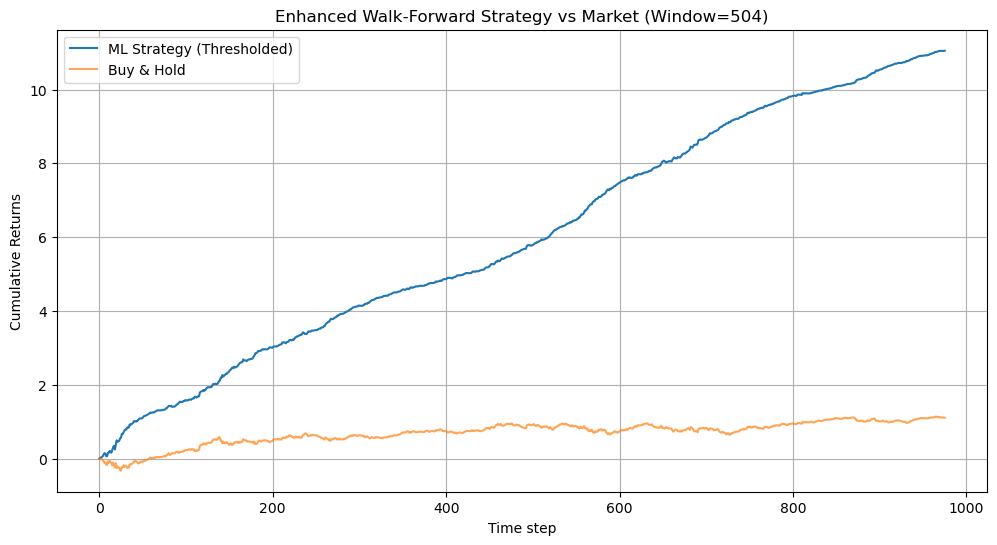

In [31]:
# Pick the best window (example: 252)
best_window = 504
preds_best, actuals_best, signals_best = walk_forward_threshold(
    df_enhanced, train_gradient_boosting, FEATURES_ENHANCED, TARGET, window=best_window, threshold=threshold
)
strategy_returns = signals_best * actuals_best

# Cumulative returns
cum_strategy = np.cumsum(strategy_returns)
cum_market = np.cumsum(actuals_best)

plt.figure(figsize=(12,6))
plt.plot(cum_strategy, label="ML Strategy (Thresholded)")
plt.plot(cum_market, label="Buy & Hold", alpha=0.7)
plt.title(f"Enhanced Walk-Forward Strategy vs Market (Window={best_window})")
plt.xlabel("Time step")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()


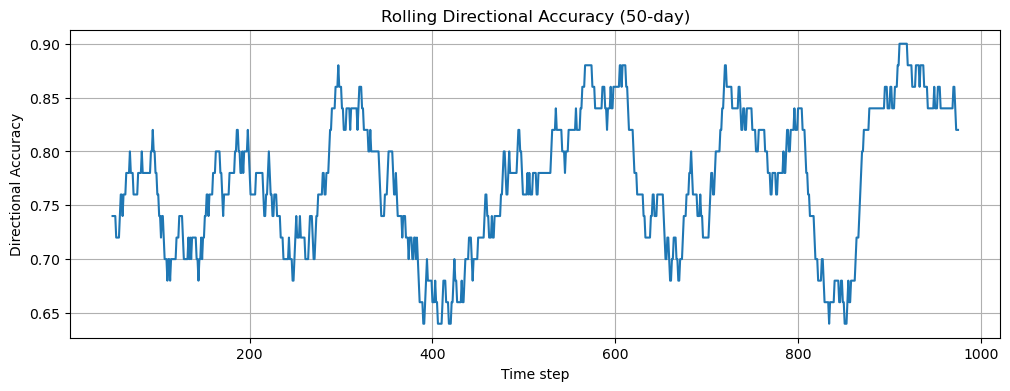

In [32]:
window_roll = 50  # 50 days rolling accuracy
rolling_da = [directional_accuracy(actuals_best[i-window_roll:i], preds_best[i-window_roll:i])
              for i in range(window_roll, len(preds_best))]

plt.figure(figsize=(12,4))
plt.plot(range(window_roll, len(preds_best)), rolling_da)
plt.title("Rolling Directional Accuracy (50-day)")
plt.xlabel("Time step")
plt.ylabel("Directional Accuracy")
plt.grid(True)
plt.show()

=== Overfitting Diagnostic Summary ===


,Rolling DA Mean,Rolling DA Std,In-Sample RMSE Mean,In-Sample RMSE Std,Out-of-Sample RMSE Mean,Out-of-Sample RMSE Std,Max Drawdown,Sharpe Ratio,Permutation Accuracy
0,0.772916,0.06224,0.003919,0.000259,0.010022,0.010607,-0.098755,10.151395,0.479508


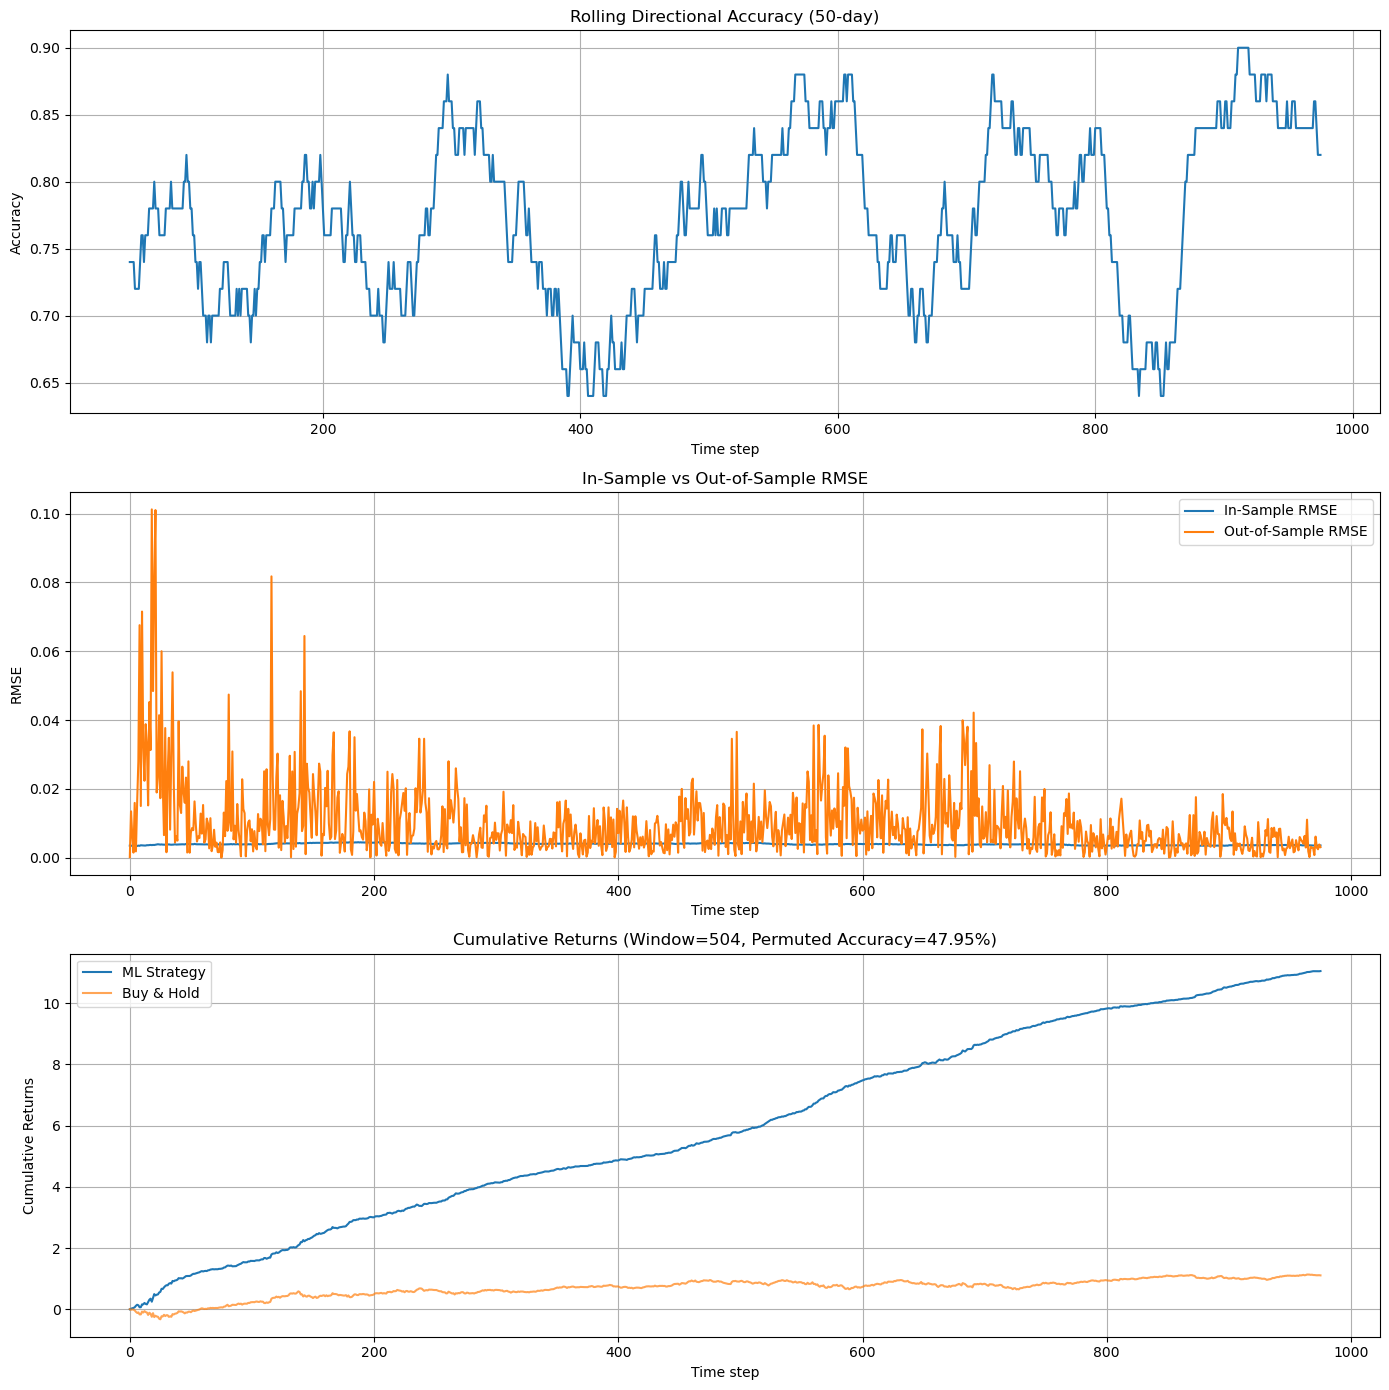

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Choose window and threshold
window = 504
threshold = 0.001

# Walk-forward predictions
preds, actuals, signals = walk_forward_threshold(
    df_enhanced, train_gradient_boosting, FEATURES_ENHANCED, TARGET, window=window, threshold=threshold
)
strategy_returns = signals * actuals

# --- 1️⃣ Rolling Directional Accuracy ---
rolling_window = 50
rolling_da = [
    directional_accuracy(actuals[i-rolling_window:i], preds[i-rolling_window:i])
    for i in range(rolling_window, len(preds))
]

# --- 2️⃣ In-sample vs Out-of-sample RMSE ---
in_sample_rmse = []
out_sample_rmse = []

for i in range(window, len(df_enhanced)):
    train = df_enhanced.iloc[i-window:i]
    test = df_enhanced.iloc[i:i+1]

    X_train = train[FEATURES_ENHANCED]
    y_train = train[TARGET]
    X_test = test[FEATURES_ENHANCED]
    y_test_val = test[TARGET].values[0]

    model = train_gradient_boosting(X_train, y_train)
    
    # In-sample RMSE
    y_train_pred = model.predict(X_train)
    in_sample_rmse.append(np.sqrt(np.mean((y_train - y_train_pred)**2)))
    
    # Out-of-sample RMSE
    y_pred = model.predict(X_test)[0]
    out_sample_rmse.append(np.sqrt((y_test_val - y_pred)**2))

# --- 3️⃣ Permutation Test ---
np.random.seed(42)
df_perm = df_enhanced.copy()
df_perm[TARGET] = np.random.permutation(df_perm[TARGET].values)

preds_perm, actuals_perm, signals_perm = walk_forward_threshold(
    df_perm, train_gradient_boosting, FEATURES_ENHANCED, TARGET, window=window, threshold=threshold
)
perm_accuracy = directional_accuracy(actuals_perm, preds_perm)

# --- 4️⃣ Summary Statistics ---
summary = {
    "Rolling DA Mean": np.mean(rolling_da),
    "Rolling DA Std": np.std(rolling_da),
    "In-Sample RMSE Mean": np.mean(in_sample_rmse),
    "In-Sample RMSE Std": np.std(in_sample_rmse),
    "Out-of-Sample RMSE Mean": np.mean(out_sample_rmse),
    "Out-of-Sample RMSE Std": np.std(out_sample_rmse),
    "Max Drawdown": np.min(np.cumsum(strategy_returns) - np.maximum.accumulate(np.cumsum(strategy_returns))),
    "Sharpe Ratio": np.sqrt(252) * np.mean(strategy_returns) / np.std(strategy_returns),
    "Permutation Accuracy": perm_accuracy
}

summary_df = pd.DataFrame(summary, index=[0])
print("=== Overfitting Diagnostic Summary ===")
display(summary_df)

# --- 5️⃣ Plots ---
fig, axs = plt.subplots(3,1, figsize=(14,14))

# Rolling directional accuracy
axs[0].plot(range(rolling_window, len(preds)), rolling_da)
axs[0].set_title("Rolling Directional Accuracy (50-day)")
axs[0].set_ylabel("Accuracy")
axs[0].set_xlabel("Time step")
axs[0].grid(True)

# In-sample vs out-of-sample RMSE
axs[1].plot(range(len(in_sample_rmse)), in_sample_rmse, label="In-Sample RMSE")
axs[1].plot(range(len(out_sample_rmse)), out_sample_rmse, label="Out-of-Sample RMSE")
axs[1].set_title("In-Sample vs Out-of-Sample RMSE")
axs[1].set_ylabel("RMSE")
axs[1].set_xlabel("Time step")
axs[1].legend()
axs[1].grid(True)

# Cumulative returns comparison
cum_strategy = np.cumsum(strategy_returns)
cum_market = np.cumsum(actuals)
axs[2].plot(cum_strategy, label="ML Strategy")
axs[2].plot(cum_market, label="Buy & Hold", alpha=0.7)
axs[2].set_title(f"Cumulative Returns (Window={window}, Permuted Accuracy={perm_accuracy:.2%})")
axs[2].set_xlabel("Time step")
axs[2].set_ylabel("Cumulative Returns")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()
